In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# Common imports
import numpy as np
import pandas as pd
import os
import math


# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mnist-data/train.csv
/kaggle/input/mnist-data/test.csv


In [2]:
# Load the Data
train = pd.read_csv("/kaggle/input/mnist-data/train.csv")
test = pd.read_csv("/kaggle/input/mnist-data/test.csv")

In [3]:
train.head(5)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
train.describe()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,...,42000.000000,42000.000000,42000.000000,42000.00000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0
mean,4.456643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.219286,0.117095,0.059024,0.02019,0.017238,0.002857,0.0,0.0,0.0,0.0
std,2.887730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.312890,4.633819,3.274488,1.75987,1.894498,0.414264,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.00000,254.000000,62.000000,0.0,0.0,0.0,0.0


In [5]:
test.head(5)

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
test.describe()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,...,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.0,28000.0,28000.0,28000.0,28000.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.164607,0.073214,0.028036,0.011250,0.006536,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.473293,3.616811,1.813602,1.205211,0.807475,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,253.000000,254.000000,193.000000,187.000000,119.000000,0.0,0.0,0.0,0.0,0.0


In [7]:
X_train_full = train.iloc[:, 1:785]
y_train_full = train.iloc[:, 0]

X_test = test.iloc[:, 0:784]

In [8]:
#Split the data
X_train, X_validation, y_train, y_validation = train_test_split(X_train_full, y_train_full, test_size = 0.2,random_state = 1212)

In [9]:
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print('X_validation:', X_validation.shape)
print('y_validation:', y_validation.shape)

X_train: (33600, 784)
y_train: (33600,)
X_validation: (8400, 784)
y_validation: (8400,)


In [10]:
x_train_re = X_train.to_numpy().reshape(33600, 28, 28)
y_train_re = y_train.values
x_validation_re = X_validation.to_numpy().reshape(8400, 28, 28)
y_validation_re = y_validation.values
x_test_re = test.to_numpy().reshape(28000, 28, 28)

In [11]:
print('x_train:', x_train_re.shape)
print('y_train:', y_train_re.shape)
print('x_validation:', x_validation_re.shape)
print('y_validation:', y_validation_re.shape)
print('x_test:', x_test_re.shape)


x_train: (33600, 28, 28)
y_train: (33600,)
x_validation: (8400, 28, 28)
y_validation: (8400,)
x_test: (28000, 28, 28)


In [12]:
(_, IMAGE_WIDTH, IMAGE_HEIGHT) = x_train_re.shape
IMAGE_CHANNELS = 1

print('IMAGE_WIDTH:', IMAGE_WIDTH);
print('IMAGE_HEIGHT:', IMAGE_HEIGHT);
print('IMAGE_CHANNELS:', IMAGE_CHANNELS);

IMAGE_WIDTH: 28
IMAGE_HEIGHT: 28
IMAGE_CHANNELS: 1


In [13]:
pd.DataFrame(x_train_re[0])

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,155,155,12,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,254,254,103,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,254,254,55,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,254,254,20,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,254,170,6,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,242,37,0,0,0,0,0,0,0,0


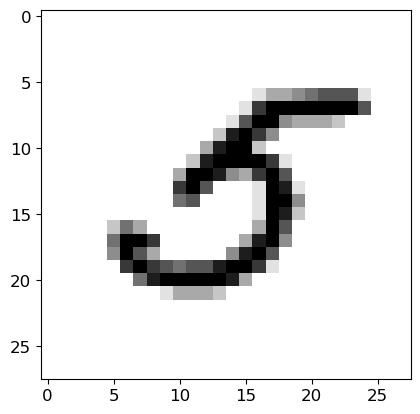

In [14]:
# Visualize the data
plt.imshow(x_train_re[5], cmap=plt.cm.binary)
plt.show()

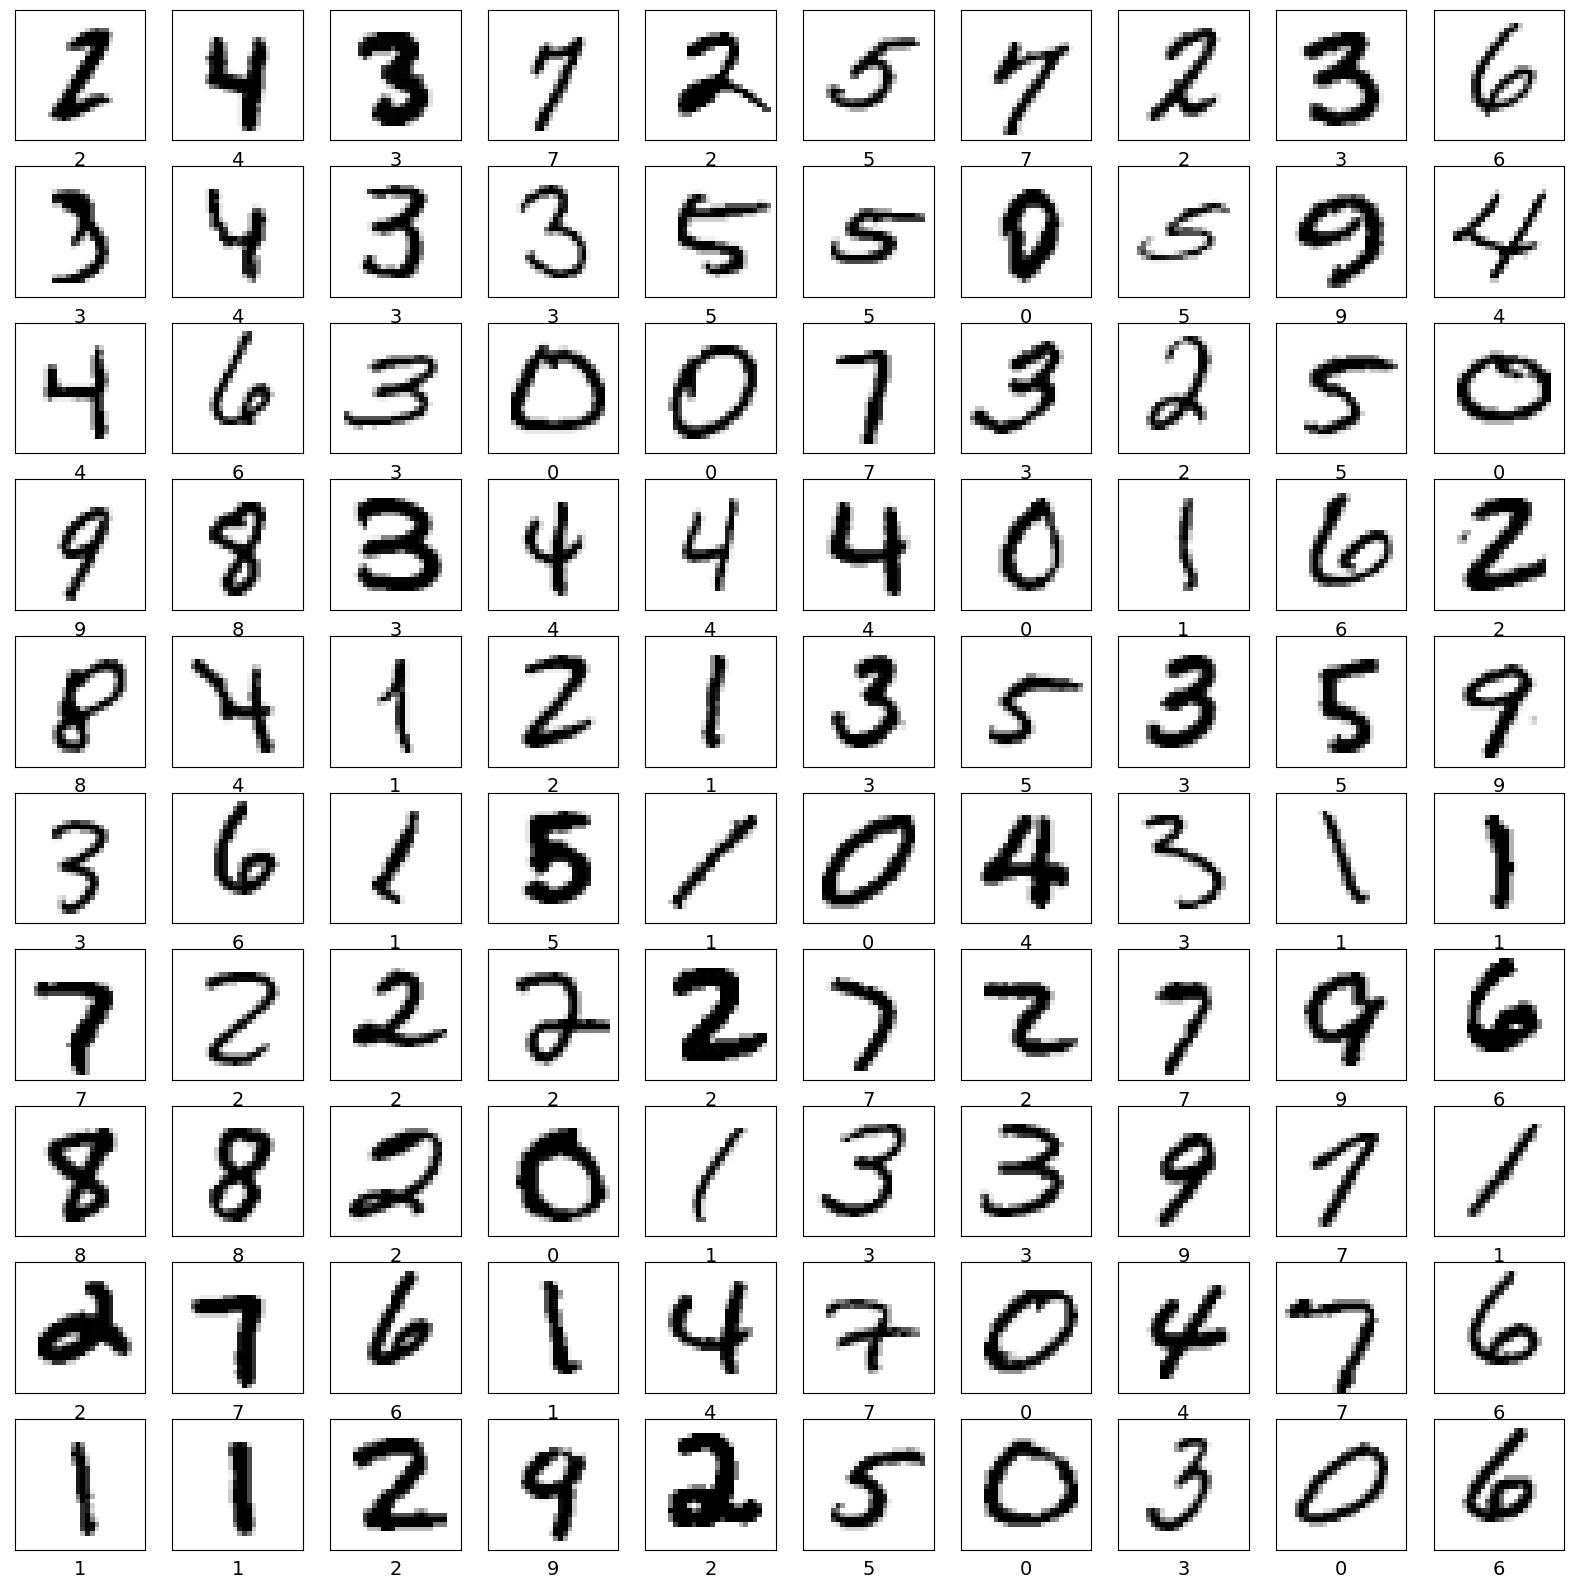

In [15]:
numbers_to_display = 100
num_cells = math.ceil(math.sqrt(numbers_to_display))
plt.figure(figsize=(20,20))
for i in range(numbers_to_display):
    plt.subplot(num_cells, num_cells, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train_re[i], cmap=plt.cm.binary)
    plt.xlabel(y_train_re[i])
plt.show()

In [16]:
# Reshaping train,test and validation data
x_train_with_chanels = x_train_re.reshape(
    x_train_re.shape[0],
    IMAGE_WIDTH,
    IMAGE_HEIGHT,
    IMAGE_CHANNELS
)

x_validation_with_chanels = x_validation_re.reshape(
    x_validation_re.shape[0],
    IMAGE_WIDTH,
    IMAGE_HEIGHT,
    IMAGE_CHANNELS
)

x_test_with_chanels = x_test_re.reshape(
    x_test_re.shape[0],
    IMAGE_WIDTH,
    IMAGE_HEIGHT,
    IMAGE_CHANNELS
)

In [17]:
print('x_train_with_chanels:', x_train_with_chanels.shape)
print('x_validation_with_chanels:', x_validation_with_chanels.shape)
print('x_test_with_chanels:', x_test_with_chanels.shape)

x_train_with_chanels: (33600, 28, 28, 1)
x_validation_with_chanels: (8400, 28, 28, 1)
x_test_with_chanels: (28000, 28, 28, 1)


In [18]:
# Normalize train,test and validation data
x_train_normalized = x_train_with_chanels / 255
x_validation_normalized = x_validation_with_chanels / 255
x_test_normalized = x_test_with_chanels / 255

In [19]:
x_train_normalized[3][10]

array([[0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.01176471],
       [0.54117647],
       [0.99607843],
       [0.92156863],
       [0.52156863],
       [0.52156863],
       [0.50196078],
       [0.17647059],
       [0.79607843],
       [0.97647059],
       [0.18039216],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ]])

In [20]:
# Creating input pipeline
train_ds = tf.data.Dataset.from_tensor_slices((x_train_normalized, y_train_re))
train_ds = train_ds.shuffle(1000).batch(40)
valid_ds = tf.data.Dataset.from_tensor_slices((x_validation_normalized, y_validation_re))
valid_ds = valid_ds.batch(40)

In [21]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Convolution2D(
    input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS),
    kernel_size=15,
    filters=256, 
    strides=1,
    activation=tf.keras.activations.relu,
    padding='same',
    kernel_initializer=tf.keras.initializers.VarianceScaling()
))

model.add(tf.keras.layers.MaxPooling2D(
    pool_size=(2, 2),
    strides=(2, 2)
))

model.add(tf.keras.layers.Convolution2D(
    kernel_size=12,
    filters=256, 
    strides=1,
    activation=tf.keras.activations.relu,
    padding='same',
    kernel_initializer=tf.keras.initializers.VarianceScaling()
))

model.add(tf.keras.layers.MaxPooling2D(
    pool_size=(2, 2),
    strides=(2, 2)
))

model.add(tf.keras.layers.Convolution2D(
    kernel_size=10,
    filters=256, 
    strides=1,
    activation=tf.keras.activations.relu,
    padding='same',
    kernel_initializer=tf.keras.initializers.VarianceScaling()
))

model.add(tf.keras.layers.MaxPooling2D(
    pool_size=(2, 2),
    strides=(2, 2)
))

model.add(tf.keras.layers.Convolution2D(
    kernel_size=8,
    filters=256, 
    strides=1,
    activation=tf.keras.activations.relu,
    padding='same',
    kernel_initializer=tf.keras.initializers.VarianceScaling()
))

model.add(tf.keras.layers.MaxPooling2D(
    pool_size=(2, 2),
    strides=(2, 2)
))

model.add(tf.keras.layers.Flatten())

model.add(keras.layers.BatchNormalization())

model.add(tf.keras.layers.Dense(
    units=1024,
    activation=tf.keras.activations.relu
))

model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(
    units=10,
    activation=tf.keras.activations.softmax,
    kernel_initializer=tf.keras.initializers.VarianceScaling()
))

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 256)       57856     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 256)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 256)       9437440   
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 256)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 256)         6553856   
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 3, 3, 256)        0

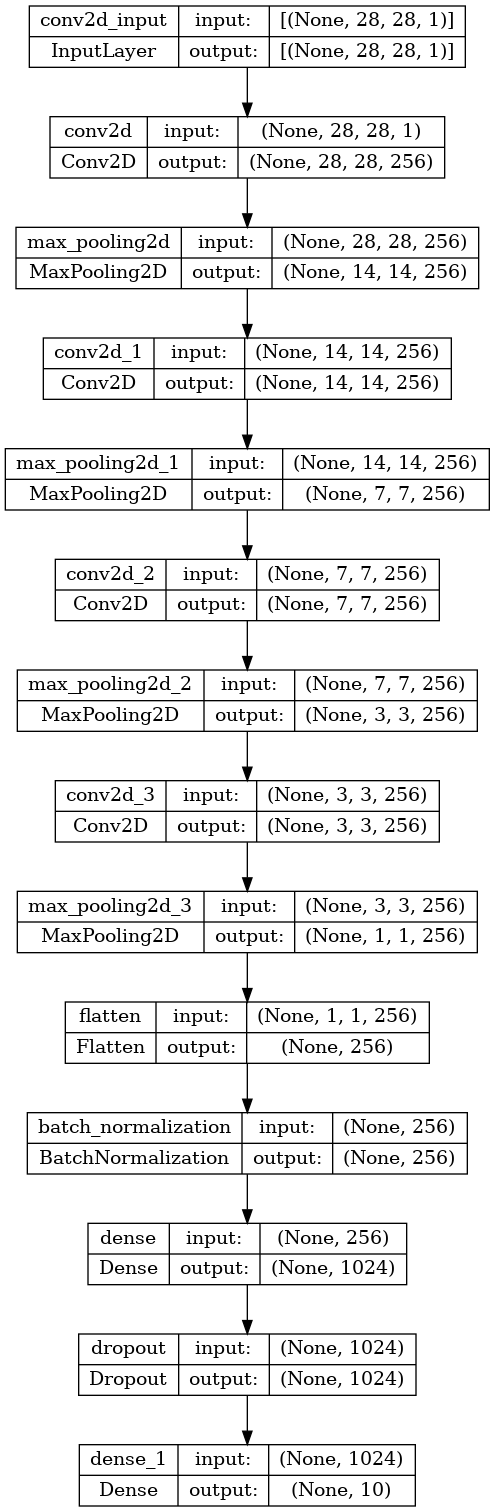

In [23]:
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
)

In [24]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile( loss="sparse_categorical_crossentropy",
               optimizer= adam_optimizer,
               metrics=["accuracy"])

In [25]:
# early_stopping = EarlyStopping(
#     monitor='val_loss',
#     patience=5,
#     verbose=1,
#     mode='min',
#     restore_best_weights=True
# )

In [26]:
history = model.fit(train_ds, epochs=35, validation_data=valid_ds)

Epoch 1/35
840/840 [==============================] - 59s 55ms/step - loss: 0.2184 - accuracy: 0.9323 - val_loss: 0.1616 - val_accuracy: 0.9508
Epoch 2/35
840/840 [==============================] - 47s 56ms/step - loss: 0.0700 - accuracy: 0.9789 - val_loss: 0.1055 - val_accuracy: 0.9708
Epoch 3/35
840/840 [==============================] - 49s 58ms/step - loss: 0.0512 - accuracy: 0.9848 - val_loss: 0.0834 - val_accuracy: 0.9806
Epoch 4/35
840/840 [==============================] - 49s 58ms/step - loss: 0.0390 - accuracy: 0.9881 - val_loss: 0.1159 - val_accuracy: 0.9699
Epoch 5/35
840/840 [==============================] - 48s 58ms/step - loss: 0.0304 - accuracy: 0.9909 - val_loss: 0.0502 - val_accuracy: 0.9873
Epoch 6/35
840/840 [==============================] - 49s 58ms/step - loss: 0.0274 - accuracy: 0.9910 - val_loss: 0.4185 - val_accuracy: 0.9043
Epoch 7/35
840/840 [==============================] - 49s 58ms/step - loss: 0.0233 - accuracy: 0.9937 - val_loss: 0.0701 - val_accuracy:

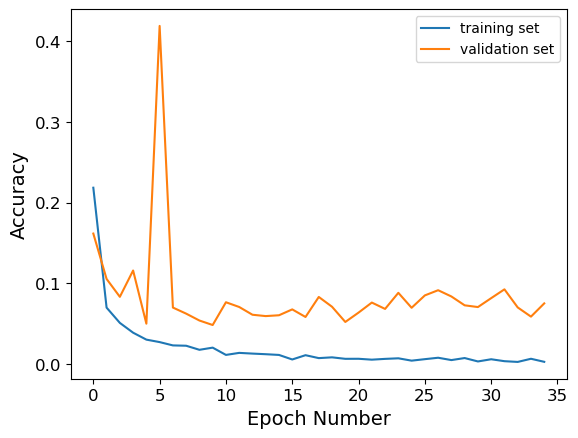

In [27]:
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.plot(history.history['loss'], label='training set')
plt.plot(history.history['val_loss'], label='validation set')
plt.legend()

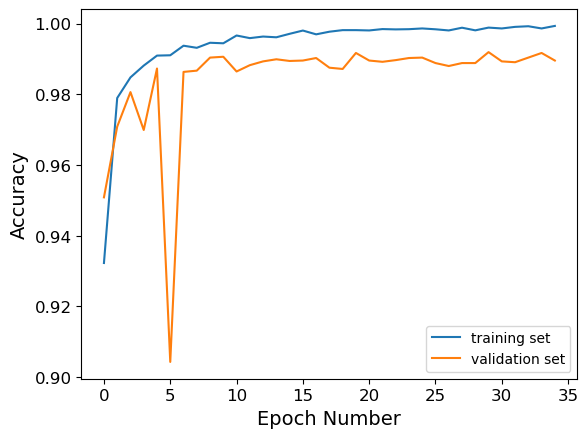

In [28]:
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.plot(history.history['accuracy'], label='training set')
plt.plot(history.history['val_accuracy'], label='validation set')
plt.legend()

In [29]:
# Performance of Training Dataset
train_loss, train_accuracy = model.evaluate(x_train_normalized, y_train)

1050/1050 [==============================] - 15s 13ms/step - loss: 0.0095 - accuracy: 0.9979


In [30]:
# Performance of Validation Dataset
validation_loss, validation_accuracy = model.evaluate(x_validation_normalized, y_validation)

263/263 [==============================] - 4s 15ms/step - loss: 0.0753 - accuracy: 0.9895


In [31]:
model_name = 'digits_recognition_cnn.h5'
model.save(model_name, save_format='h5')

In [32]:
loaded_model = tf.keras.models.load_model(model_name)

In [33]:
# Prediction for validation dataset
predictions = loaded_model.predict([x_validation_normalized])

263/263 [==============================] - 3s 12ms/step


In [34]:
pd.DataFrame(predictions)

,0,1,2,3,4,5,6,7,8,9
0,7.017724e-18,1.000000e+00,8.518124e-16,2.381519e-19,1.109990e-15,5.840554e-19,1.192544e-18,2.874969e-15,7.388633e-15,4.344208e-19
1,3.339284e-24,1.018011e-20,7.354136e-21,1.000000e+00,1.029523e-29,3.321845e-21,3.494080e-26,1.085039e-22,1.615532e-22,1.132476e-19
2,7.991712e-27,1.287904e-25,2.314854e-25,1.421712e-26,1.430645e-26,5.915576e-28,7.983477e-29,5.794385e-30,1.000000e+00,5.060710e-28
3,5.486160e-15,1.000000e+00,3.532359e-13,6.258055e-16,2.194008e-12,1.160910e-15,1.529747e-15,1.115359e-12,1.432065e-12,1.269003e-15
4,1.057415e-16,1.238471e-17,5.514687e-18,3.452309e-17,9.653308e-13,7.348066e-17,6.075136e-20,1.044695e-14,3.616210e-16,1.000000e+00
...,...,...,...,...,...,...,...,...,...,...
8395,4.235958e-18,3.847709e-13,9.664573e-15,1.218902e-18,1.000000e+00,2.194565e-15,1.793355e-14,8.567917e-13,3.915000e-14,3.204451e-12
8396,6.483736e-23,5.769499e-32,1.526707e-26,1.301204e-23,1.835000e-29,1.000000e+00,9.147958e-24,2.297852e-29,4.412245e-28,7.642794e-24
8397,9.130782e-14,5.556791e-12,1.302557e-12,7.770507e-14,2.696053e-11,2.670370e-13,3.949193e-17,1.000000e+00,2.061669e-12,7.225641e-12
8398,3.162339e-09,1.044216e-09,1.425924e-09,8.921863e-10,1.479541e-08,2.590758e-05,9.999741e-01,3.040561e-12,9.241652e-09,5.398322e-10


In [35]:
# Convert predictions in 1D array of integers
predictions = np.argmax(predictions, axis=1)
pd.DataFrame(predictions)

,0
0,1
1,3
2,8
3,1
4,9
...,...
8395,4
8396,5
8397,7
8398,6


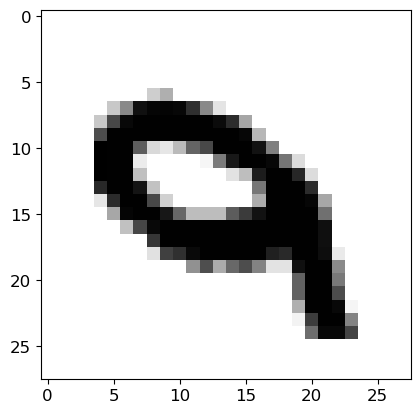

In [36]:
plt.imshow(x_validation_normalized[5].reshape((IMAGE_WIDTH, IMAGE_HEIGHT)), cmap=plt.cm.binary)
plt.show()

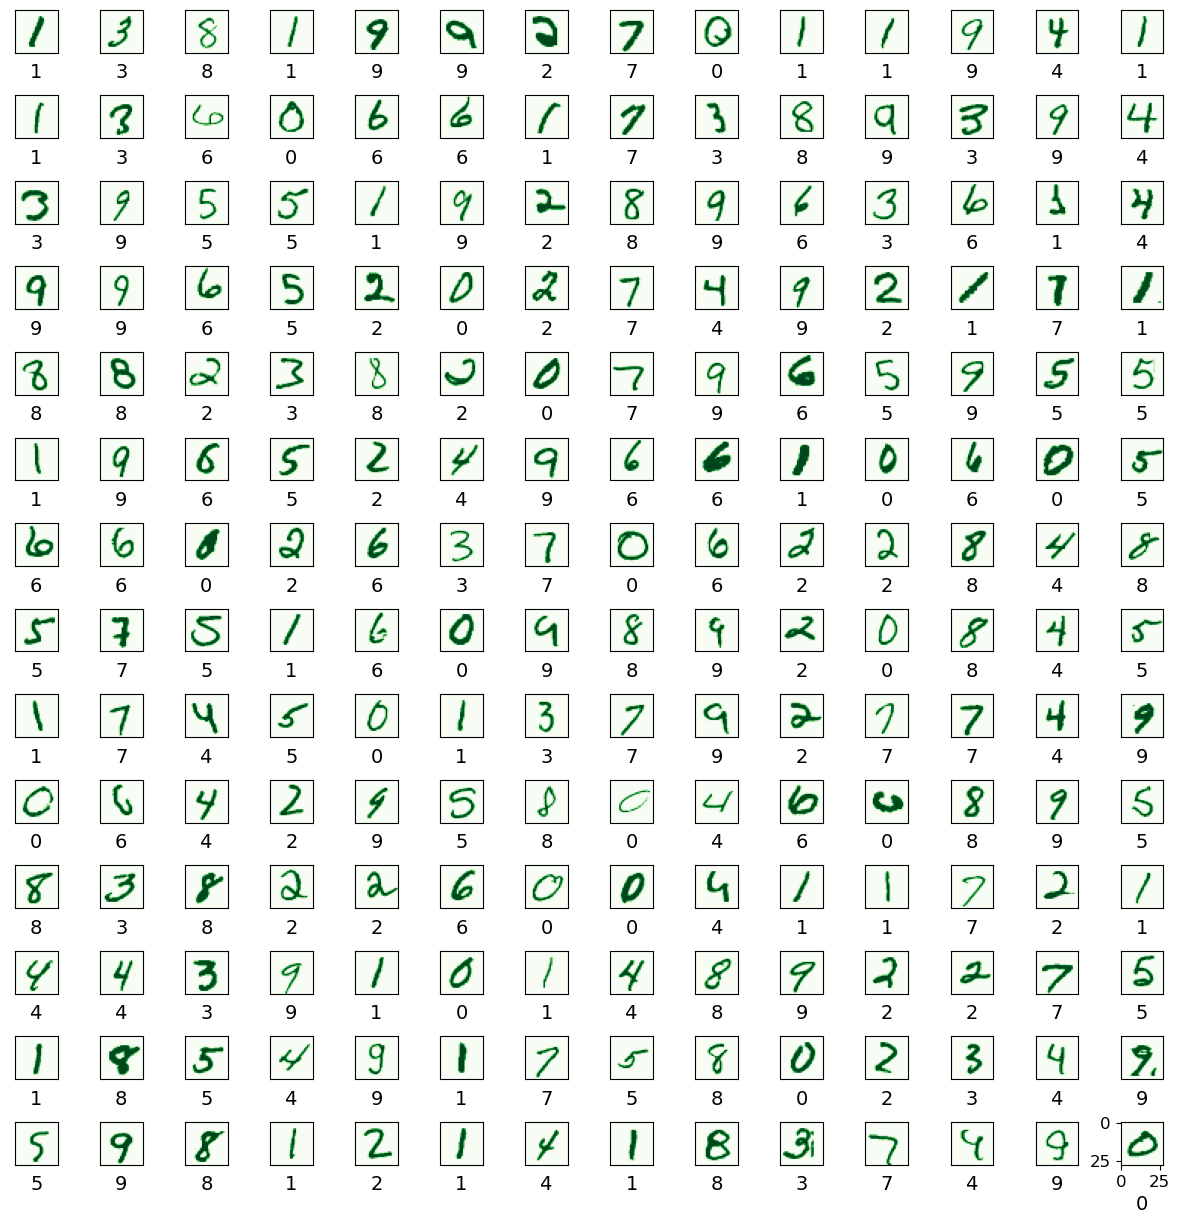

In [37]:
numbers_to_display = 196
num_cells = math.ceil(math.sqrt(numbers_to_display))
plt.figure(figsize=(15, 15))

for plot_index in range(numbers_to_display):    
    predicted_label = predictions[plot_index]
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    color_map = 'Greens' if predicted_label == y_validation_re[plot_index] else 'Reds'
    plt.subplot(num_cells, num_cells, plot_index + 1)
    plt.imshow(x_validation_normalized[plot_index].reshape((IMAGE_WIDTH, IMAGE_HEIGHT)), cmap=color_map)
    plt.xlabel(predicted_label)

plt.subplots_adjust(hspace=1, wspace=0.5)
plt.show()

In [38]:
test_pred = loaded_model.predict([x_test_normalized])

875/875 [==============================] - 11s 12ms/step


In [39]:
pd.DataFrame(test_pred)

,0,1,2,3,4,5,6,7,8,9
0,7.815026e-17,1.938982e-14,1.000000e+00,1.165765e-15,3.195788e-17,1.195613e-19,8.172725e-17,1.089635e-14,2.108938e-17,1.632167e-18
1,1.000000e+00,6.893328e-14,5.530866e-11,1.198315e-14,4.921239e-13,3.376720e-13,5.005583e-11,5.628991e-11,6.967803e-14,1.030659e-12
2,5.511115e-17,4.357770e-18,8.970330e-18,7.389778e-18,8.645977e-13,4.549622e-17,4.652339e-20,1.078103e-15,3.378658e-17,1.000000e+00
3,9.995213e-01,2.757678e-11,1.338740e-07,9.857568e-09,5.490832e-10,1.030172e-07,2.172700e-07,6.400934e-10,1.807107e-09,4.782229e-04
4,7.626199e-15,9.753471e-13,2.065368e-13,1.000000e+00,1.269554e-17,4.361240e-13,3.271688e-16,2.509062e-14,6.667751e-13,1.062923e-10
...,...,...,...,...,...,...,...,...,...,...
27995,1.608696e-19,2.143853e-21,8.455038e-21,3.390130e-20,1.039661e-15,7.029345e-20,3.840387e-23,1.613189e-18,1.671540e-20,1.000000e+00
27996,2.733006e-14,2.246340e-13,5.272172e-13,2.208423e-14,8.573638e-13,2.021861e-14,1.256472e-18,1.000000e+00,5.985407e-14,1.193804e-12
27997,6.745165e-28,2.566282e-24,4.090219e-25,1.000000e+00,7.972105e-34,2.835353e-25,1.435574e-30,4.941372e-26,1.687998e-25,3.892544e-21
27998,8.651176e-16,4.109018e-17,1.126631e-16,3.890120e-16,1.005583e-12,3.608053e-16,4.115508e-19,3.369922e-15,9.134182e-17,1.000000e+00


In [40]:
test_pred = np.argmax(test_pred, axis=1)
pd.DataFrame(test_pred)

,0
0,2
1,0
2,9
3,0
4,3
...,...
27995,9
27996,7
27997,3
27998,9


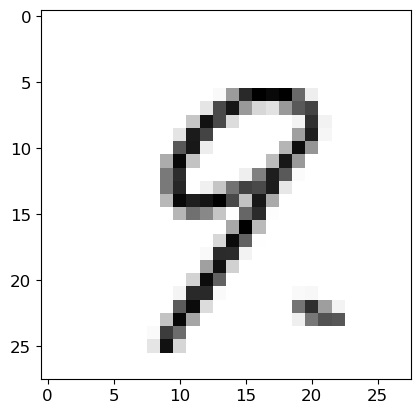

In [41]:
plt.imshow(x_test_normalized[2].reshape((IMAGE_WIDTH, IMAGE_HEIGHT)), cmap=plt.cm.binary)
plt.show()

In [42]:
test_pred.shape

(28000,)

In [43]:
submission_df = pd.DataFrame({'ImageId': range(1, len(test_pred) + 1), 'Label': test_pred})

In [44]:
submission_df.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3


In [45]:
submission_df.to_csv('submission.csv', index=False)